# DATA 620 Web Analytics
# Assignment 2 - Graph Visualization
**Gillian McGovern, Dhanya Nair, Dirk Hartog**

Instructions:

Load a graph database of your choosing from a text file or other source.  If you take a large network dataset from the web (such as from Stanford Large Network Dataset Collection), please feel free at this point to load just a small subset of the nodes and edges.

Create basic analysis on the graph, including
the graph’s diameter, and at least one other metric of your choosing.  

You may either code the functions by hand (to build your intuition and insight), or use functions in an existing package.

Use a visualization tool of your choice to display information.
Use NetworkX directly, pyviz or another tool (Gephi or
Neo4j) but you should get used to using the Python toolset.

Please record a short video (~ 5 minutes), and submit a link to the video in advance of our meet-up. You will be showing your assignment in the meet-up but it is always useful to have a recording.


## Data set

Exploring 1-mode networks with products from Amazon. The data can be found **[at this link](https://snap.stanford.edu/data/amazon0302.html)**.

As per the source page... *"Network was collected by crawling Amazon website. It is based on Customers Who Bought This Item Also Bought feature of the Amazon website. If a product i is frequently co-purchased with product j, the graph contains a directed edge from i to j."*

The data was collected in March 02 2003.

In [ ]:
import pandas as pd
import requests
import csv
import matplotlib.pyplot as plt
import networkx as net
import os
import seaborn as sns

In [ ]:
# Read in data stored in a txt file

url = 'https://raw.githubusercontent.com/D-hartog/DATA620/refs/heads/main/Assignment2/amazon0302.txt'  # Replace with the raw URL of your text file
response = requests.get(url)
text_content = response.text

In [ ]:
# Open the file
#in_file = csv.reader(open(text_content,'r'))

from_node = []
to_node = []

# Create a graph object
g = net.Graph()

for line in text_content.splitlines():
    line_split = line.split("\t")
    if line_split[0].startswith("#"):
        continue
    g.add_edge(line_split[0],line_split[1], weight = 1)

In [ ]:
# Get the number of nodes and edges

print(f'There are {len(g.nodes())} nodes and {len(g.edges())} edges in this data set')

There are 262111 nodes and 899792 edges in this data set


Since the data set is large we will take a sample of the data to create the graph and obtain metrics. We will use degree centrality to find the core of the network. From here we can trim off nodes to get a sample consisting of the nodes that have high degree centrality (nodes with degree centrality > 50).


In [ ]:
# Get degree centrality

# Compute degree centrality
deg = net.degree(g)

# Convert the DegreeView object into a dictionary in order to extract information
d = dict(deg)

# Check stats of degree centrality
print(d['0'])

# Print min degree centrality
print(f"Minimum degree {min(d.values())}")

# Print max degree centrality
print(f"Maximum degree {max(d.values())}")

5
Minimum degree 1
Maximum degree 420


In [ ]:
# Return a sorted degree list

def sorted_map(dd: dict) -> dict:
    """
    Sorts dict by its values (desc)

    :param dd: dictionary with numeric values
    :return sorted dictionary ordered by its numeric value
    """
    sorted_dict = sorted(dd.items(), key=lambda x: (-x[1], x[0]))
    return sorted_dict

# get all the nodes sorted by highest degree
ds = sorted_map(d)

# let's see top 10 nodes with the highest degree centrality
ds[:9]

[('14949', 420),
 ('4429', 405),
 ('33', 363),
 ('10519', 335),
 ('12771', 330),
 ('8', 296),
 ('297', 280),
 ('481', 278),
 ('5737', 272)]

In [ ]:
# Define a function that will trim off the nodes with a degree centrality < 50)
def trim_degrees(go, degree=1):
    go2=go.copy()
    d = dict(net.degree(go2))
    for n in go.nodes():
        if d[n] <= degree:
            #print(n)
            go2.remove_node(n)
    return go2

core100 = trim_degrees(g, degree = 100)

# Number of nodes that we are left with
len(core100.nodes())

77

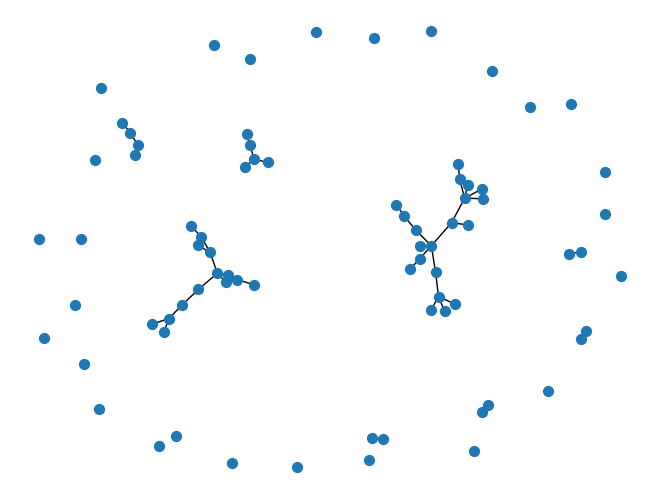

In [ ]:
# Draw network of the nodes with at least a degree centrality score of 100

net.draw(core100, with_labels=False, node_size=50)

In [ ]:
# largest connected component(LCC)

# Make sure core100 is connected before computing diameter
if not net.is_connected(core100):
    # Work with the largest connected component
    lcc = max(net.connected_components(core100), key=len)
    g_core_lcc = core100.subgraph(lcc).copy()
    print(f"Core100 is NOT fully connected. Using its largest connected component with {len(g_core_lcc.nodes())} nodes.")
else:
    g_core_lcc = core100
    print("Core100 is connected.")

# Compute Diameter :Longest shortest path in the largest connected part of core100.
diameter = net.diameter(g_core_lcc)
print(f"Diameter: {diameter}")

# Compute Average Clustering Coefficient : How tightly nodes form triangles.
avg_clustering = net.average_clustering(core100)
print(f"Average Clustering Coefficient: {avg_clustering:.4f}")

# Compute  Degree Centrality (normalized degree): Nodes with most connections (normalized)
deg_centrality = net.degree_centrality(core100)
top_nodes = sorted(deg_centrality.items(), key=lambda x: -x[1])[:5]
print("Top 5 nodes by degree centrality:")
for node, score in top_nodes:
    print(f"Node {node}: {score:.3f}")


Core100 is NOT fully connected. Using its largest connected component with 20 nodes.
Diameter: 7
Average Clustering Coefficient: 0.0766
Top 5 nodes by degree centrality:
Node 33: 0.066
Node 481: 0.066
Node 4429: 0.066
Node 8: 0.053
Node 2501: 0.053


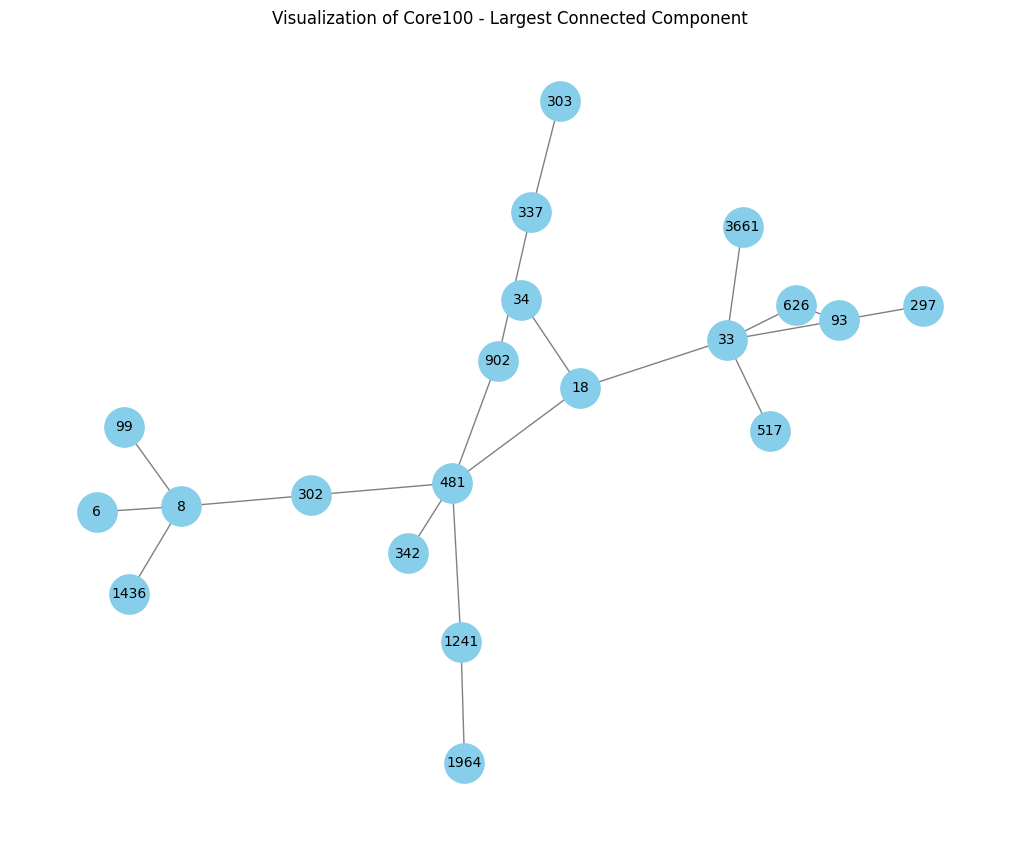

In [ ]:
# Set a layout
pos = net.spring_layout(g_core_lcc, seed=42)  # spring_layout = force-directed

plt.figure(figsize=(10, 8))
net.draw(
    g_core_lcc,
    pos,
    with_labels=True,
    node_color='skyblue',
    edge_color='gray',
    node_size=800,
    font_size=10
)
plt.title("Visualization of Core100 - Largest Connected Component")
plt.show()

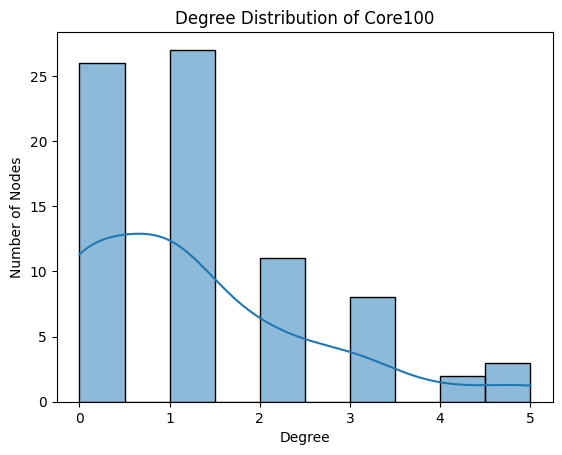

In [ ]:
# Degree Distribution
# Get degrees
degrees = [deg for _, deg in core100.degree()]

# Plot degree distribution
sns.histplot(degrees, bins=10, kde=True)
plt.title("Degree Distribution of Core100")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.show()

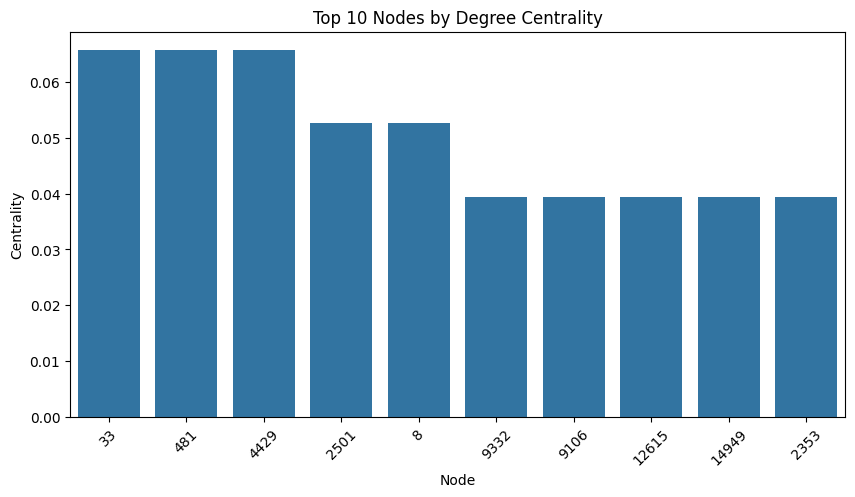

In [ ]:
# Degree Centraility
# Degree centrality as DataFrame
deg_df = pd.DataFrame(list(net.degree_centrality(core100).items()), columns=["Node", "Centrality"])

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Node", y="Centrality", data=deg_df.sort_values("Centrality", ascending=False).head(10))
plt.title("Top 10 Nodes by Degree Centrality")
plt.xticks(rotation=45)
plt.show()


**Summary**

*   The amazon dataset has 262,111 nodes which could  represent products or entities like users or pages.
*   It has 899,792 Edges which are possibly co-purchases, links, or recommendations.
*   A Minimum Degree of 1 indicates there are nodes connected to only one other node — maybe niche or isolated items.
*   A Maximum Degree of 420 suggests that it's a hub node and possibly a very popular item frequently bought with others.
*   Node '14949' is the most connected product, with 420 edges. It likely represents a very popular product that co-occurs with many others in customer purchases.
*   Only 20 of the 77 nodes form the largest connected component (LCC).
*   The diameter which is the Longest shortest path between any two nodes in the LCC is 7 hops.For a 20-node network, this is relatively sparse, suggesting the need for longer paths between important nodes
*   Average Clustering Coefficient: 0.0766 suggests a hub-and-spoke or tree-like structure rather than a tightly-knit community.
*   Degree Distribution and Degree Centrality (normalized) is visualized.
*   The graph is visualized  by LCC .Since core100 has 77 nodes, and the LCC has 20 nodes, we recommend visualizing the LCC for clarity.













